In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from autoencoder_LaSDI import AE_network, DI_network
from training_LaSDI import create_feed_dictionary, create_feed_dictionary2
from sindy_utils import *

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import seaborn as sns
import matplotlib.patches as patches
from copy import deepcopy
%matplotlib inline
import random
import subprocess as sp
from sklearn.linear_model import LinearRegression
import copy

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16149


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='0'))

In [4]:
data_path = os.getcwd() + '/fig/nCase36_ld3_p1_width100_lr5e-6_1e-4_scaledAE_scaledDI/'

save_name_AE = 'burger_AE_2022_02_13_14_40_57'
save_name_DI = 'burger_DI_2022_02_14_07_58_37'
params_AE = pickle.load(open(data_path + save_name_AE + '_params.pkl', 'rb'))
params_DI = pickle.load(open(data_path + save_name_DI + '_params.pkl', 'rb'))
params_AE['save_name'] = data_path + save_name_AE
params_DI['save_name'] = data_path + save_name_DI

In [5]:
# print(params_results['sindy_interp'][0], params_results['num_test'][0], params_results['tol2'][0], 
#       params_results['update_epoch'][0], params_results['max_epochs'][0], params_results['subsize_max'][0])
# print(params_results['widths'][0], params_results['latent_dim'][0],params_results['poly_order'][0])

# print(params['convex_knn'], params['num_test'], params['tol2'], 
#       params['update_epoch'], params['max_epochs'], params['subsize_max'])

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def silu(x):
    return x * sigmoid(x)

def NN(x, weights, biases, activation):
    """
    this networks serve as either an encoder or a decoder.
    """
    num_layers = len(weights)
    for i in range(num_layers-1):
        x = np.matmul(x, weights[i]) + biases[i]
        if activation == 'tanh':
            x = np.tanh(x)
        elif activation == 'sigmoid':
            x = sigmoid(x)
            
    # output layer (linear activation)
    x = np.matmul(x, weights[-1]) + biases[-1]
    return x

def derivative(x):
    dxdt = np.empty(x.shape)
    D = D_Lele(x.shape[0], tstop/x.shape[0])   
    for i in range(x.shape[1]):
        dxdt[:,i] = np.dot(D.toarray(), x[:,i])
    del D
    return dxdt

In [7]:
def eval_AE(test_data):     
    x_scale = 1
    x_min = 0
    if params_AE['scaled']:
        x_scale = params_AE['x_scale']
        x_min = params_AE['x_min']
    x = test_data['x'] * x_scale + x_min
    z_encoder = NN(x, params_AE['AE_params'][0], params_AE['AE_params'][1], params_AE['activation']) # encoder
    u_decoder = NN(z_encoder, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation']) # decoder
    u_decoder = (u_decoder - x_min) / x_scale
    return z_encoder, u_decoder

In [8]:
def eval_LaSDI(test_data, test_param, idx=None, knn=4):  
    timer = []
#     u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx = 0,0,0,0,0,0,0
    
    # Step 1: set up tf graph and load parameters, can be optimized, excluded from ROM computational time
    timer.append(time()) 
    include_sine = False
    include_cosine = False
    x_scale, x_min = 1, 0
    z_scale, z_min = 1, 0
    if 'include_sine' in params_DI.keys():
        include_sine = params_DI['include_sine']
    if 'include_cosine' in params_DI.keys():
        include_cosine = params_DI['include_cosine']
    if params_AE['scaled']:
        x_scale = params_AE['x_scale']
        x_min = params_AE['x_min'] 
    if params_DI['scaled']:
        z_scale = params_DI['z_scale']
        z_min = params_DI['z_min']
    x = test_data['x'] * x_scale + x_min
    z_encoder = NN(x, params_AE['AE_params'][0], params_AE['AE_params'][1], params_AE['activation']) # encoder
    u_decoder = NN(z_encoder, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation']) # decoder
    u_decoder = (u_decoder - x_min) / x_scale
    
    
    # Step 2: find the nearest neighbor (optional)
    timer.append(time()) 
    if idx == None:
        train_param = np.stack(params_DI['param'])
        idx = np.argmin(np.linalg.norm(train_param-test_param, axis=1))
    
    
    # Step 3: calculate SINDy coefficients
    timer.append(time())        
    if knn == 1:
        print(f"Index of the nearest local DI: {idx+1}")
        sindy_coeff = params_DI['DI_params'][idx]
        
    else: # KNN convex interpolation of coefficients
        dist = np.linalg.norm(train_param-test_param, axis=1)
        knn_idx = np.argsort(dist)[:knn]
        phi = np.zeros_like(knn_idx)
        if dist[knn_idx[0]] == 0: # check if the min distance is zero
            phi[0] = 1
        else:
            phi = 1 / np.linalg.norm(train_param[knn_idx]-test_param, axis=1)**2
        psi = phi / phi.sum()
        print(f"indices: {knn_idx}")
        print(f"weights: {psi}")

        sindy_coeff = np.zeros(params_DI['DI_params'][0].shape)
        for i,kidx in enumerate(knn_idx):
            sindy_coeff += psi[i] * params_DI['DI_params'][kidx]
    
    # Step 4: latent-space dynamics prediction and obtain physical dynamics
    timer.append(time())
    z_init = z_encoder[0,:] * z_scale + z_min
    z_sim = sindy_simulate(z_init, test_data['t'].squeeze(), 
                           sindy_coeff, params_DI['poly_order'], 
                           include_sine,include_cosine)
    z_sim = (z_sim - z_min) / z_scale
    u_sim = NN(z_sim, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation'])
    u_sim = (u_sim - x_min) / x_scale
    timer.append(time())
    
    dz_sim = derivative(z_sim)
    dz_encoder = derivative(z_encoder)
    
    timer1 = np.array(timer)
    timer2 = timer1[1:]
    timer_rom = timer2 - timer1[:-1]
    
    return u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom

### Interpolative prediction

In [9]:
def process_data(data, vel, nt, scaled=False, option=None):
    # select component
    if vel == 1:
        data['data'][0]['x'] = data['data'][0].pop('u')
        data['data'][0]['dx'] = data['data'][0].pop('du')
        data['data'][0].pop('v')
        data['data'][0].pop('dv')
    elif vel == 2:
        data['data'][0]['x'] = data['data'][0].pop('v')
        data['data'][0]['dx'] = data['data'][0].pop('dv')
        data['data'][0].pop('u')
        data['data'][0].pop('du')
    elif vel == 3:
        data['data'][0]['x'] = np.hstack((data['data'][0]['u'], data['data'][0]['v']))
        data['data'][0]['dx'] = np.hstack((data['data'][0]['du'], data['data'][0]['dv']))
        
    # select time steps
    data['data'][0]['x'] = data['data'][0]['x'][:nt+1]
    data['data'][0]['dx'] = data['data'][0]['dx'][:nt+1]
    data_x = np.copy(data['data'][0]['x'])
    data_dx = np.copy(data['data'][0]['dx'])

    # normalize data
    if scaled:
        if option == 1:
            data['data'][0]['x'] = data.transform(test_data['data'][0]['x'])
            data['data'][0]['dx'] = data.transform(test_data['data'][0]['dx'])
        elif option == 2:
            print(x_max, dx_max)
            data['data'][0]['x'] = data['data'][0]['x'] / x_max
            data['data'][0]['dx'] = data['data'][0]['dx'] / dx_max
        elif option == 3:
            data['data'][0]['x'] = (data['data'][0]['x']-x_ref) / x_scale
            data['data'][0]['dx'] = (data['data'][0]['dx']-dx_ref) / dx_scale
    return data, data_x, data_dx

In [10]:
Re = params_AE['pde']['Re']
nx = params_AE['pde']['nx']
ny = nx
nt = params_AE['pde']['nt']
tstop = params_AE['pde']['tstop']
t_test = tstop
vel = 3
knn = 1
amp_arr = np.array([0.78])
width_arr = np.array([1.1])
test_data = pickle.load(open(f"./data/local1_Re{Re}_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "rb"))

ic = params_AE['pde']['ic']

In [11]:
nt_test = int(t_test/tstop*nt)
t = np.linspace(0,t_test,nt_test+1)
test_data, test_data_x, test_data_dx = process_data(test_data, vel, nt_test)

In [12]:
z_encoder, u_decoder = eval_AE(test_data['data'][0])
u_decoder = u_decoder.squeeze()
print(u_decoder.shape, z_encoder.shape)

(201, 7200) (201, 3)


In [13]:
# Max relative error of all time steps
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')

max autoencoder error: 2.02 %


In [14]:
u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom = eval_LaSDI(test_data['data'][0],
                                                                                    test_data['param'][0])
time_rom = timer_rom[1:].sum()
print(u_sim.shape, z_sim.shape)
print(f'time: {time_rom:.2f} s')

indices: [17 23 11 16]
weights: [1. 0. 0. 0.]
(201, 7200) (201, 3)
time: 0.02 s


In [15]:
# Max relative error of all time steps
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_lasdi = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max lasdi error: {err_lasdi.max():.2f} %')

max autoencoder error: 2.02 %
max lasdi error: 8.97 %


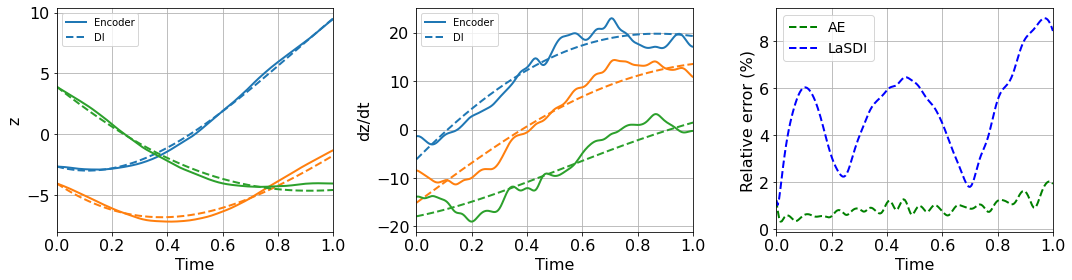

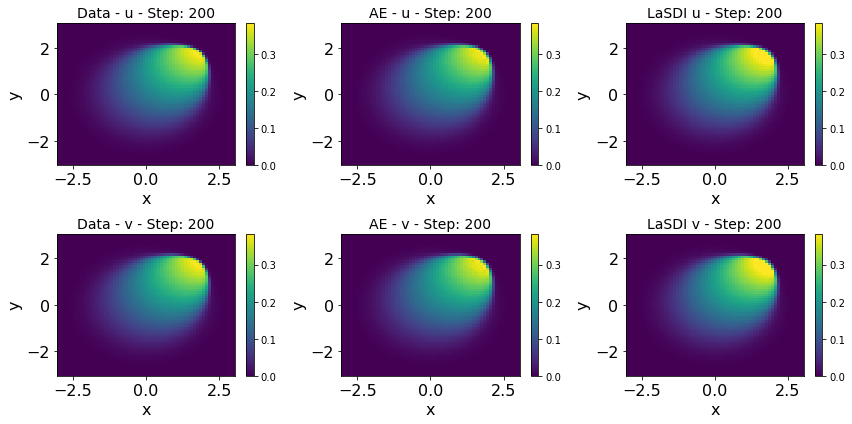

In [16]:
[xv,yv] = np.meshgrid(np.linspace(-3,3,nx),np.linspace(-3,3,ny),indexing='xy')
step = int(nt_test/1)
# step = 0
vmin_x = 0
vmax_x = test_data_x[step,:].max()
vmin_dx = 0
vmax_dx = test_data_dx[step,:].max()/2


fig1 = plt.figure(figsize=(15,4))
ax = fig1.add_subplot(131)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], lw=2, c=cmap(i))
    ax.plot(t, z_sim[:,i], '--', lw=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('z', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['Encoder', 'DI'])
ax.grid()
# ax.set_title('AE latent dynamics', fontsize=16)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(132)
for i in range(z_encoder.shape[1]):
    ax.plot(t, dz_encoder[:,i], lw=2, c=cmap(i))
    ax.plot(t, dz_sim[:,i], '--', lw=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('dz/dt', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['Encoder', 'DI'])
ax.grid()
# ax.set_title('AE latent dynamics', fontsize=16)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(133)
ax.plot(t, err_decoder, 'g--', linewidth=2, label='AE')
ax.plot(t, err_lasdi, 'b--', linewidth=2, label='LaSDI')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Relative error (%)', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.grid()
ax.legend(fontsize=14, loc='upper left')
ax.set_xlim(t.min(),t.max())

plt.tight_layout()
plt.savefig(data_path + f"/latent_dynamics_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.png")


fig1 = plt.figure(figsize=(12,6))
ax = fig1.add_subplot(231)
p_u = ax.pcolor(xv, yv, test_data_x[step,:nx*ny].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - u - Step: {step}', fontsize=14)

ax = fig1.add_subplot(232)
p_u = ax.pcolor(xv, yv, u_decoder[step,:nx*ny].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'AE - u - Step: {step}', fontsize=14)

ax = fig1.add_subplot(233)
p_u = ax.pcolor(xv, yv, u_sim[step,:nx*ny].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'LaSDI u - Step: {step}', fontsize=14)

ax = fig1.add_subplot(234)
p_u = ax.pcolor(xv, yv, test_data_x[step,nx*ny:].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'Data - v - Step: {step}', fontsize=14)

ax = fig1.add_subplot(235)
p_u = ax.pcolor(xv, yv, u_decoder[step,nx*ny:].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'AE - v - Step: {step}', fontsize=14)

ax = fig1.add_subplot(236)
p_u = ax.pcolor(xv, yv, u_sim[step,nx*ny:].reshape(ny,nx), shading='auto', vmin=vmin_x, vmax=vmax_x)
cb_u = fig1.colorbar(p_u, ax=ax)
ax.set_xlabel('x', fontsize=16)
ax.set_ylabel('y', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_title(f'LaSDI v - Step: {step}', fontsize=14)

plt.tight_layout()
plt.savefig(data_path + f"inter_pred_A{amp_arr[0]:.2f}_W{width_arr[0]:.2f}.png")

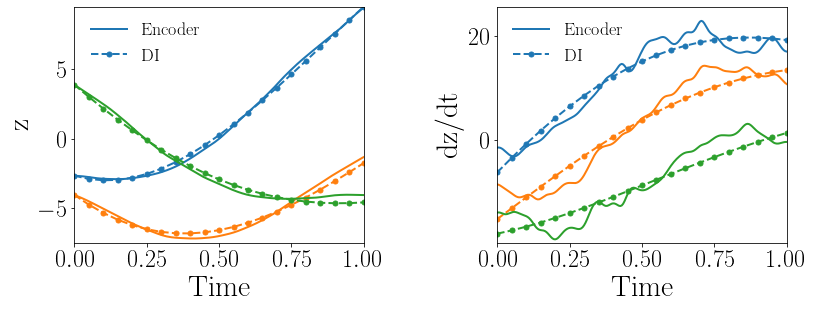

In [17]:
plt.rcParams.update({"font.size": 30,
                     "text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,10)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_ylim(z_sim.min()*1.1,z_sim.max()*1.0)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper left', frameon=False, fontsize=18)
# ax.grid()
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min()*1.1,dz_sim.max()*1.3)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper left', frameon=False, fontsize=18)
# ax.grid()

plt.tight_layout()
plt.savefig(data_path + f"2Dburger_latent_dynamics.png",bbox_inches='tight')

### Extended domain

In [18]:
knn = 3
res_nstep = nt
res_name = f'mean'
nt_test = int(t_test/tstop*nt)
t = np.linspace(0,t_test,nt_test+1)
vel = 3 # 1: u, 2: v, 3: u and v

na = 21
nw = na
# amp_test = params_DI['param'][:,0]
# width_test = params_DI['param'][:,1]
amp_test = np.linspace(0.7,0.9,na)
width_test = np.linspace(0.9,1.1,nw)

amp_size = amp_test.size
width_size = width_test.size
num_case = amp_size * width_size
max_err_lasdi = np.zeros([amp_size, width_size])
max_err_AE = np.zeros([amp_size, width_size])
sindy_idx = np.zeros([amp_size, width_size])
test_data_all = pickle.load(open(f"./data/local{num_case}_Re{Re}_tstop{tstop:.1f}_nt{nt}_nx{nx}.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(amp_test):
    for j,w in enumerate(width_test):
        print(f'{count+1}/{num_case}:')
        test_data = {}
        test_data['data'] = [deepcopy(test_data_all['data'][count])]
        test_data['param'] = [deepcopy(test_data_all['param'][count])]
        test_data, test_data_x,_ = process_data(test_data, vel, nt_test)
            
        u_decoder,u_sim,_,_,_,_,idx,t_rom = eval_LaSDI(test_data['data'][0], test_data['param'][0], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # max error of all time steps
        max_err_AE[i,j] = (np.linalg.norm(test_data_x - u_decoder, axis=1) \
                                        / np.linalg.norm(test_data_x, axis=1)*100).max()
        max_err_lasdi[i,j] = (np.linalg.norm(test_data_x - u_sim, axis=1) \
                                        / np.linalg.norm(test_data_x, axis=1)*100).max()
        count += 1
end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 38.4 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Average speed up: {speed_up:.2f}')
for i,t in enumerate(timer_rom):
    print(f'ROM time{i}: {t:.8f} s')

1/441:
indices: [0 1 6]
weights: [1. 0. 0.]
2/441:
indices: [0 1 6]
weights: [0.8547486  0.09497207 0.05027933]
3/441:
indices: [0 1 7]
weights: [0.45454545 0.45454545 0.09090909]
4/441:
indices: [1 0 7]
weights: [0.8547486  0.09497207 0.05027933]
5/441:
indices: [1 0 2]
weights: [1. 0. 0.]
6/441:
indices: [1 2 7]
weights: [0.8547486  0.09497207 0.05027933]
7/441:
indices: [1 2 8]
weights: [0.45454545 0.45454545 0.09090909]
8/441:
indices: [2 1 8]
weights: [0.8547486  0.09497207 0.05027933]
9/441:
indices: [2 3 1]
weights: [1. 0. 0.]
10/441:
indices: [2 3 8]
weights: [0.8547486  0.09497207 0.05027933]
11/441:
indices: [2 3 8]
weights: [0.45454545 0.45454545 0.09090909]
12/441:
indices: [3 2 9]
weights: [0.8547486  0.09497207 0.05027933]
13/441:
indices: [3 2 4]
weights: [1. 0. 0.]
14/441:
indices: [3 4 9]
weights: [0.8547486  0.09497207 0.05027933]
15/441:
indices: [3 4 9]
weights: [0.45454545 0.45454545 0.09090909]
16/441:
indices: [ 4  3 10]
weights: [0.8547486  0.09497207 0.05027933

In [19]:
print(f'max relative error (AE): {max_err_AE.max()}')
print(f'max relative error (LaSDI): {max_err_lasdi.max()}')
a_grid, w_grid = np.meshgrid(amp_test, width_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

a_grid, w_grid = np.meshgrid(np.arange(amp_test.size), np.arange(width_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params_DI['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

max relative error (AE): 4.273493430629219
max relative error (LaSDI): 22.20248810399345


In [20]:
# # heat map of max relative errors
# tol = 5
# sns.set(font_scale=1.3)
# def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
#     if dtype == 'int':
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     else:
#         fmt1 = '.1f'
#     rect = []
# #     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     for i in range(len(idx_param)):
#         print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
#         idd = idx_param[i][0]
# #         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#         rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect2 = deepcopy(rect)
    
#     if max_err.size < 100:
#         fig = plt.figure(figsize=(10,5))
#     else:
#         fig = plt.figure(figsize=(18,9))
    
#     # local SINDy indices
#     ax = fig.add_subplot(121)
#     sindy_idx = sindy_idx.astype(int)
#     sns.heatmap(sindy_idx, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                 annot=True, fmt='d', annot_kws={'size':14}, 
#                 cbar=False, cmap='Spectral', robust=True, vmin=1, vmax=len(idx_param)+5)
#     for i in rect:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('Width', fontsize=16)
#     ax.set_ylabel('Amplitude', fontsize=16)
#     ax.set_title('Index of Selected Local DI', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 

#     # heatmap of max relative errors
#     fontsize = 14
#     if max_err.max() >= 10:
#         fontsize = 12
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     ax = fig.add_subplot(122)
#     cbar_ax = fig.add_axes([0.99, 0.19, 0.018, 0.7])
#     if label == 'Residual Norm':
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
#     else:
# #         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
# #                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
# #                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
#     for i in rect2:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('Width', fontsize=16)
#     ax.set_ylabel('Amplitude', fontsize=16)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
#     plt.tight_layout()
#     if label == 'Residual Norm':
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_resNorm.png', bbox_inches='tight')
#     elif label == 'autoencoder':
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_maxRelErr_AE.png', bbox_inches='tight')
#     else:
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_maxRelErr_lasdi.png', bbox_inches='tight')

#     plt.show()

In [21]:
# heat map of max relative errors
plt.rcParams.update({"text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

tol = 5
sns.set(font_scale=1.3)
def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
    if dtype == 'int':
        max_err = max_err.astype(int)
        fmt1 = 'd'
    else:
        fmt1 = '.1f'
    rect = []
#     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    for i in range(len(idx_param)):
        print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
        idd = idx_param[i][0]
#         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
        rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    rect2 = deepcopy(rect)
    
    if max_err.size < 100:
        fig = plt.figure(figsize=(5,5))
    else:
        fig = plt.figure(figsize=(9,9))

    # heatmap of max relative errors
    fontsize = 14
    if max_err.max() >= 10:
        fontsize = 12
        max_err = max_err.astype(int)
        fmt1 = 'd'
    ax = fig.add_subplot(111)
    cbar_ax = fig.add_axes([0.99, 0.19, 0.02, 0.7])
    if label == 'Residual Norm':
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
    else:
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
    for i in rect2:
        ax.add_patch(i)
        
    # format text labels
    fmt = '{:0.2f}'
    xticklabels = []
    for item in ax.get_xticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        xticklabels += [item]
    yticklabels = []
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        yticklabels += [item]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('Width', fontsize=24)
    ax.set_ylabel('Amplitude', fontsize=24)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
    plt.tight_layout()
    if label == 'Residual Norm':
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_resNorm.png', bbox_inches='tight')
    elif label == 'autoencoder':
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_maxRelErr_AE.png', bbox_inches='tight')
    else:
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_maxRelErr_lasdi.png', bbox_inches='tight')

    plt.show()

idx: 0, param: [0.7 0.9]
idx: 84, param: [0.7  0.94]
idx: 168, param: [0.7  0.98]
idx: 252, param: [0.7  1.02]
idx: 336, param: [0.7  1.06]
idx: 420, param: [0.7 1.1]
idx: 4, param: [0.74 0.9 ]
idx: 88, param: [0.74 0.94]
idx: 172, param: [0.74 0.98]
idx: 256, param: [0.74 1.02]
idx: 340, param: [0.74 1.06]
idx: 424, param: [0.74 1.1 ]
idx: 8, param: [0.78 0.9 ]
idx: 92, param: [0.78 0.94]
idx: 176, param: [0.78 0.98]
idx: 260, param: [0.78 1.02]
idx: 344, param: [0.78 1.06]
idx: 428, param: [0.78 1.1 ]
idx: 12, param: [0.82 0.9 ]
idx: 96, param: [0.82 0.94]
idx: 180, param: [0.82 0.98]
idx: 264, param: [0.82 1.02]
idx: 348, param: [0.82 1.06]
idx: 432, param: [0.82 1.1 ]
idx: 16, param: [0.86 0.9 ]
idx: 100, param: [0.86 0.94]
idx: 184, param: [0.86 0.98]
idx: 268, param: [0.86 1.02]
idx: 352, param: [0.86 1.06]
idx: 436, param: [0.86 1.1 ]
idx: 20, param: [0.9 0.9]
idx: 104, param: [0.9  0.94]
idx: 188, param: [0.9  0.98]
idx: 272, param: [0.9  1.02]
idx: 356, param: [0.9  1.06]
idx:

/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


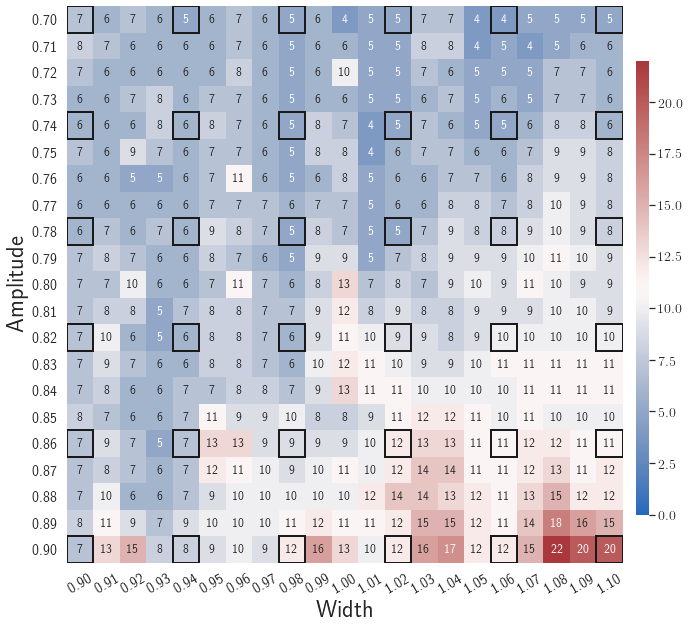

In [22]:
max_err_heatmap(max_err_lasdi, sindy_idx, idx_list, idx_param, dtype='float')

idx: 0, param: [0.7 0.9]
idx: 84, param: [0.7  0.94]
idx: 168, param: [0.7  0.98]
idx: 252, param: [0.7  1.02]
idx: 336, param: [0.7  1.06]
idx: 420, param: [0.7 1.1]
idx: 4, param: [0.74 0.9 ]
idx: 88, param: [0.74 0.94]
idx: 172, param: [0.74 0.98]
idx: 256, param: [0.74 1.02]
idx: 340, param: [0.74 1.06]
idx: 424, param: [0.74 1.1 ]
idx: 8, param: [0.78 0.9 ]
idx: 92, param: [0.78 0.94]
idx: 176, param: [0.78 0.98]
idx: 260, param: [0.78 1.02]
idx: 344, param: [0.78 1.06]
idx: 428, param: [0.78 1.1 ]
idx: 12, param: [0.82 0.9 ]
idx: 96, param: [0.82 0.94]
idx: 180, param: [0.82 0.98]
idx: 264, param: [0.82 1.02]
idx: 348, param: [0.82 1.06]
idx: 432, param: [0.82 1.1 ]
idx: 16, param: [0.86 0.9 ]
idx: 100, param: [0.86 0.94]
idx: 184, param: [0.86 0.98]
idx: 268, param: [0.86 1.02]
idx: 352, param: [0.86 1.06]
idx: 436, param: [0.86 1.1 ]
idx: 20, param: [0.9 0.9]
idx: 104, param: [0.9  0.94]
idx: 188, param: [0.9  0.98]
idx: 272, param: [0.9  1.02]
idx: 356, param: [0.9  1.06]
idx:

/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


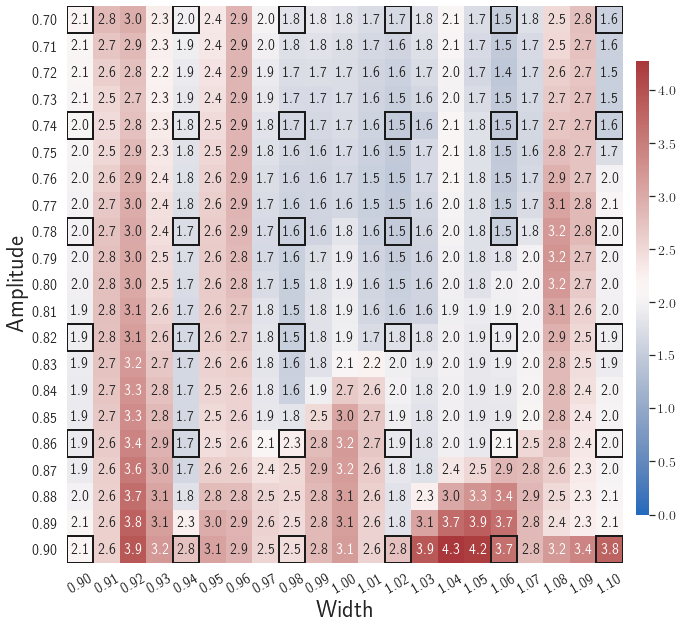

In [23]:
max_err_heatmap(max_err_AE, sindy_idx, idx_list, idx_param, dtype='float', label='autoencoder')